<a href="https://colab.research.google.com/github/shabububu/ww2db_data/blob/master/20191124_ww2color_beta_300epochs_eval3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Attempt to reproduce: https://github.com/emilwallner/Coloring-greyscale-images/blob/master/Beta-version/beta_version.ipynb using images from ww2db.com

In [0]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, CSVLogger
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from IPython.display import Image, display


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Set my drive path for convenience
my_drive = "drive/My Drive/Learning/CapstoneData/"

# Get training image path
train_path = os.path.join(my_drive, 'ww2db', '256', 'ww2db_20191102_256x256_a_1600_color')
!ls "$train_path" | wc -l

1600


In [0]:
# Get images
X = []
for filename in os.listdir(train_path):
    #print(os.path.join(train_path, filename))
    X.append(img_to_array(load_img(os.path.join(train_path, filename))))
X = np.array(X, dtype=float)

In [0]:
# Set up train and test data
#split = int(0.95*len(X))
split = 1500
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [0]:
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mse', 'accuracy'])

In [0]:
# Create results directory
import datetime
timestamp='{:%Y%m%d_%H%M%S}'.format(datetime.datetime.now())
result_path = os.path.join(my_drive, 'ww2db', 'results', "20191124_ww2color_beta_300epochs_eval3_"+timestamp)
print("Result directory '{}'".format(result_path))
if not os.path.exists(result_path):
    print("Creating new directory: {}".format(result_path))
    tf.gfile.MkDir(result_path)
else:
    print("Directory already exists: {}".format(result_path))

!ls "$result_path"

Result directory 'drive/My Drive/Learning/CapstoneData/ww2db/results/20191124_ww2color_beta_300epochs_eval3_20191124_154435'
Creating new directory: drive/My Drive/Learning/CapstoneData/ww2db/results/20191124_ww2color_beta_300epochs_eval3_20191124_154435


In [0]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 50
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Validation Set
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128

# Train model      
tensorboard = TensorBoard(log_dir=os.path.join(result_path,'tensorboard_logs'))
#earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save_acc = ModelCheckpoint(os.path.join(result_path,'weights.{epoch:03d}-{val_acc:.4f}-{val_loss:.4f}.hdf5'), save_best_only=True, monitor='val_acc', mode='max')
mcp_save_loss = ModelCheckpoint(os.path.join(result_path,'weights.{epoch:03d}-{val_acc:.4f}-{val_loss:.4f}.hdf5'), save_best_only=True, monitor='val_loss', mode='min')
csv_logger = CSVLogger(os.path.join(result_path,'log.csv'), separator=',', append=False)

model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard, mcp_save_acc, mcp_save_loss, csv_logger], epochs=300, steps_per_epoch=30, validation_data=(Xtest, Ytest))











Epoch 1/300
30/30 [==============================] - 52s 2s/step - loss: 0.2333 - mean_squared_error: 0.2333 - acc: 0.5070 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_acc: 0.5187

Epoch 2/300
30/30 [==============================] - 43s 1s/step - loss: 0.0082 - mean_squared_error: 0.0082 - acc: 0.5442 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_acc: 0.4477
Epoch 3/300
30/30 [==============================] - 47s 2s/step - loss: 0.0080 - mean_squared_error: 0.0080 - acc: 0.5447 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_acc: 0.4475
Epoch 4/300
30/30 [==============================] - 45s 1s/step - loss: 0.0080 - mean_squared_error: 0.0080 - acc: 0.5419 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_acc: 0.4472
Epoch 5/300
30/30 [==============================] - 46s 2s/step - loss: 0.0083 - mean_squared_error: 0.0083 - acc: 0.5400 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_acc: 0.4472
Epoch 6/300
30/30 [=====

In [0]:
# Save last model (just in case)
model_json = model.to_json()
with open(os.path.join(result_path,'final-model.json'), "w") as json_file:
    json_file.write(model_json)
model.save_weights(os.path.join(result_path,'final-model.h5'))

In [0]:
!ls "$result_path"

final-model.h5			weights.045-0.6265-0.0067.hdf5
final-model.json		weights.047-0.6350-0.0065.hdf5
log.csv				weights.054-0.6095-0.0065.hdf5
tensorboard_logs		weights.057-0.6296-0.0065.hdf5
weights.001-0.5187-0.0080.hdf5	weights.058-0.6104-0.0064.hdf5
weights.011-0.5732-0.0077.hdf5	weights.067-0.6280-0.0064.hdf5
weights.018-0.4659-0.0075.hdf5	weights.068-0.6279-0.0064.hdf5
weights.022-0.5036-0.0075.hdf5	weights.071-0.6117-0.0064.hdf5
weights.023-0.4625-0.0074.hdf5	weights.085-0.6292-0.0063.hdf5
weights.024-0.4930-0.0073.hdf5	weights.087-0.6297-0.0062.hdf5
weights.026-0.5601-0.0071.hdf5	weights.098-0.6196-0.0062.hdf5
weights.027-0.5486-0.0071.hdf5	weights.109-0.6203-0.0062.hdf5
weights.028-0.6195-0.0070.hdf5	weights.114-0.6268-0.0061.hdf5
weights.034-0.6029-0.0068.hdf5	weights.146-0.6242-0.0060.hdf5
weights.035-0.6321-0.0067.hdf5	weights.180-0.6388-0.0064.hdf5


In [0]:
# Load best model from training (best validation accuracy)
# TODO: Figure out how to load it automatically, instead of having to look up the best model by hand.
best_model_path=os.path.join(result_path,'weights.180-0.6388-0.0064.hdf5')
model.load_weights(best_model_path)

In [0]:
# Validation Set images
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

100/100 [==============================] - 1s 11ms/step
[0.006384389940649271, 0.006384389707818627, 0.6387782394886017]


In [0]:
# Now testing on black and white images without color ground truth
test_path = os.path.join(my_drive, 'ww2db', '256', 'ww2db_test_bw_256x256')

!ls "$test_path" | wc -l

26


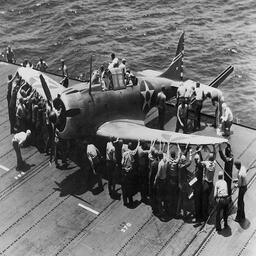

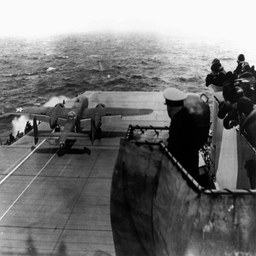

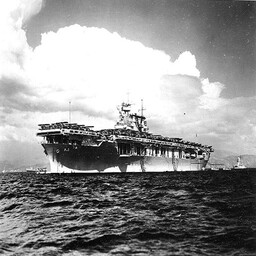

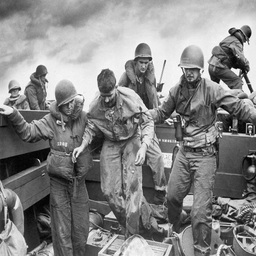

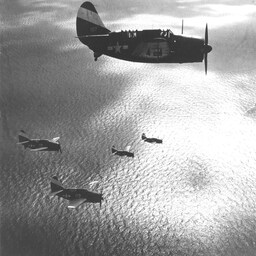

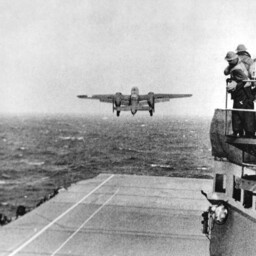

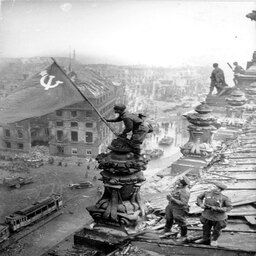

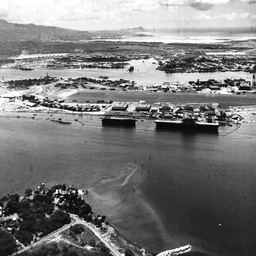

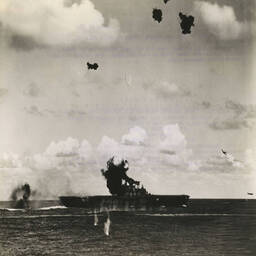

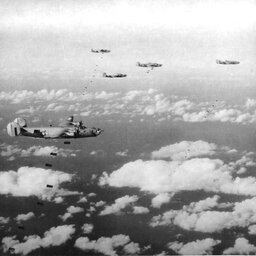

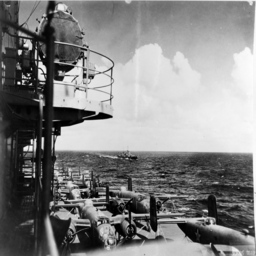

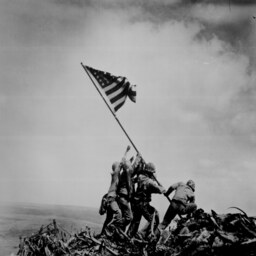

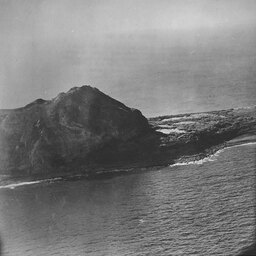

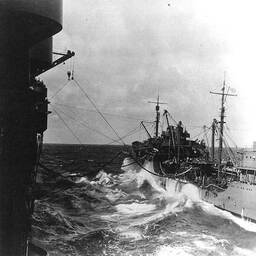

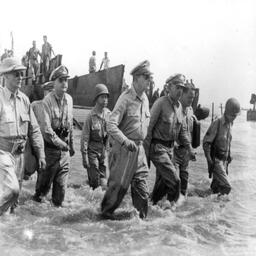

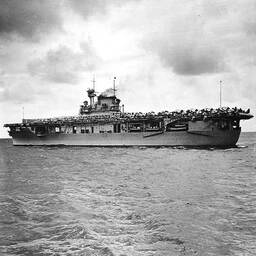

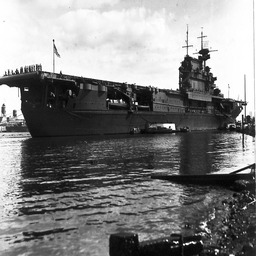

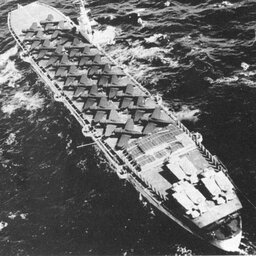

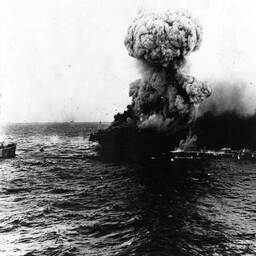

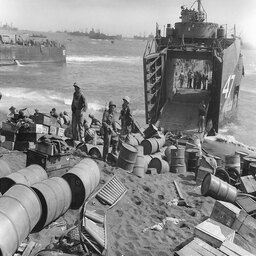

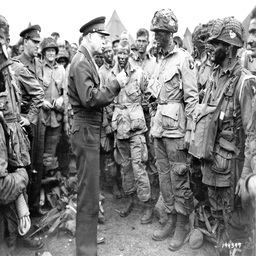

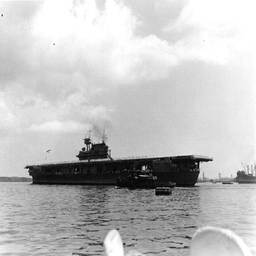

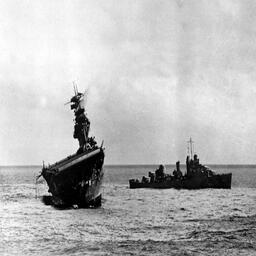

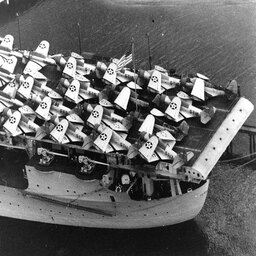

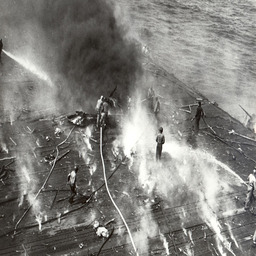

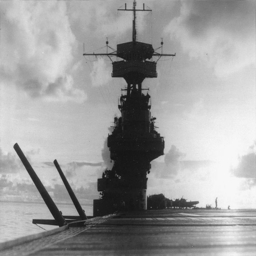

In [0]:
for filename in os.listdir(test_path):
    #print(os.path.join(test_path, filename))
    display(Image(os.path.join(test_path, filename)))

In [0]:
color_me = []
for filename in os.listdir(test_path):
    #print(os.path.join(test_path, filename))
    color_me.append(img_to_array(load_img(os.path.join(test_path, filename))))
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

In [0]:
# Test model
output = model.predict(color_me)
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave(os.path.join(result_path, "img_"+str(i)+"_b.png"), lab2rgb(cur))

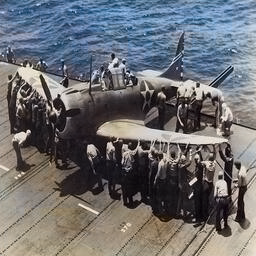

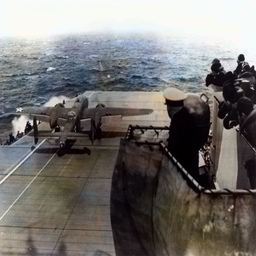

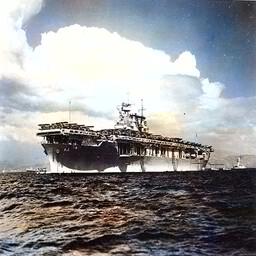

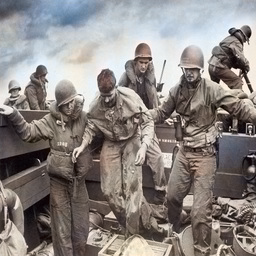

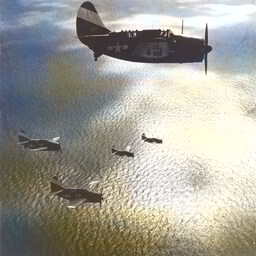

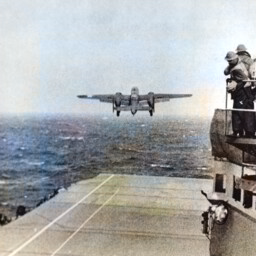

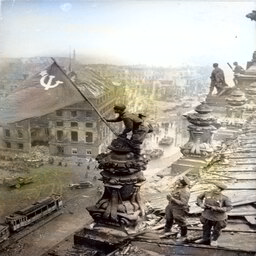

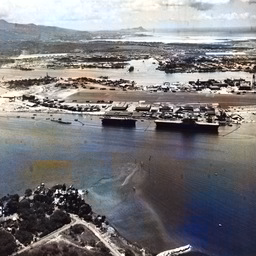

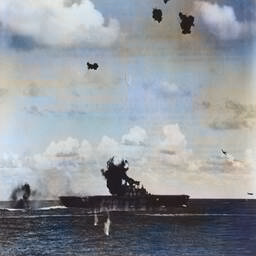

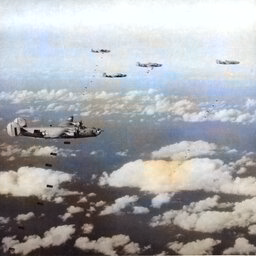

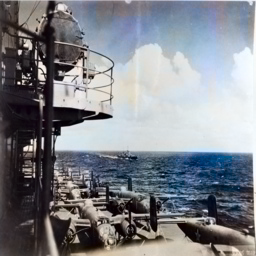

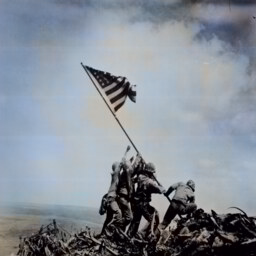

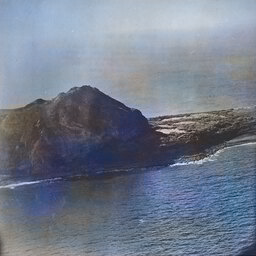

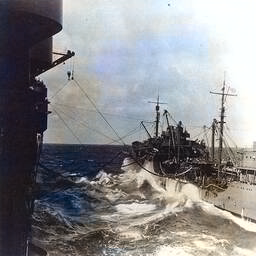

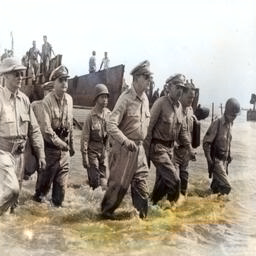

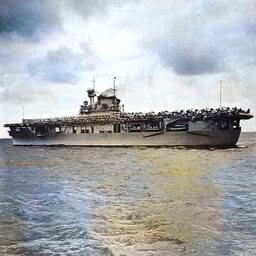

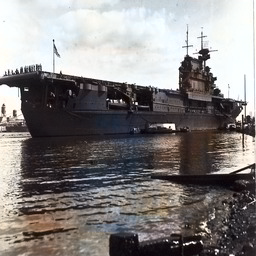

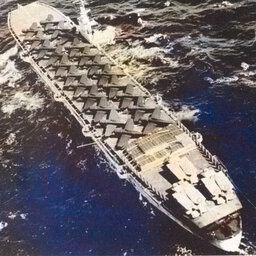

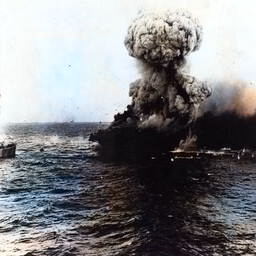

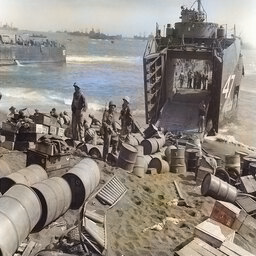

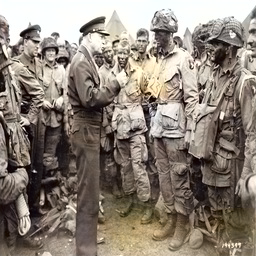

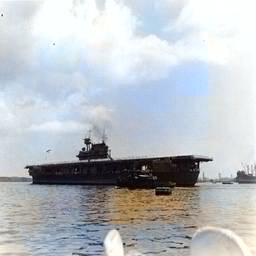

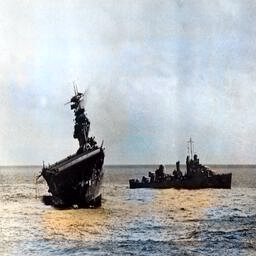

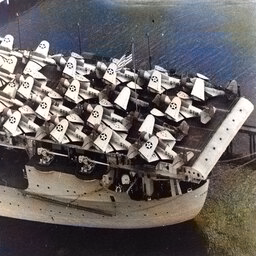

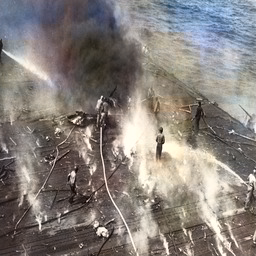

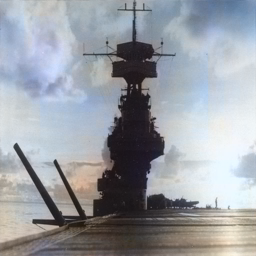

In [0]:
for filename in os.listdir(result_path):
    if filename.endswith('.png') and filename.startswith('img_'):
        #print(os.path.join(result_path, filename))
        display(Image(os.path.join(result_path, filename)))

In [0]:
# Testing on held out colored set
test_path = os.path.join(my_drive, 'ww2db', '256', 'ww2db_20191102_256x256_a_test_122')

# Get evaluation images (non-validation)
eval_set = []
for filename in os.listdir(test_path):
    eval_set.append(img_to_array(load_img(os.path.join(test_path, filename))))
eval_set = np.array(eval_set, dtype=float)

eval_set_X = rgb2lab(1.0/255*eval_set)[:,:,:,0]
eval_set_X = eval_set_X.reshape(eval_set_X.shape+(1,))
eval_set_Y = rgb2lab(1.0/255*eval_set)[:,:,:,1:]
eval_set_Y = eval_set_Y / 128
print(model.evaluate(eval_set_X, eval_set_Y))

122/122 [==============================] - 1s 10ms/step
[0.006217133085869375, 0.006217132986630084, 0.7042551548754583]


In [0]:
# Test model
output = model.predict(eval_set_X)
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = eval_set_X[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave(os.path.join(result_path, "test_img_"+str(i)+".png"), lab2rgb(cur))

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 5 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


In [0]:
import pandas as pd
result_path='drive/My Drive/Learning/CapstoneData/ww2db/results/20191124_ww2color_beta_300epochs_eval3_20191124_154435'
train_history = pd.read_csv(os.path.join(result_path, 'log.csv'))
train_history

epoch       acc      loss  ...   val_acc  val_loss  val_mean_squared_error
0        0  0.507027  0.233308  ...  0.518670  0.007984                0.007984
1        1  0.544230  0.008210  ...  0.447676  0.008085                0.008085
2        2  0.544698  0.008033  ...  0.447550  0.008042                0.008042
3        3  0.541861  0.008037  ...  0.447239  0.008845                0.008845
4        4  0.539960  0.008304  ...  0.447239  0.008203                0.008203
..     ...       ...       ...  ...       ...       ...                     ...
295    295  0.700243  0.003966  ...  0.618310  0.006700                0.006700
296    296  0.707606  0.003816  ...  0.594655  0.006755                0.006755
297    297  0.708318  0.003766  ...  0.593889  0.007023                0.007023
298    298  0.710198  0.003851  ...  0.622581  0.006534                0.006534
299    299  0.706400  0.003820  ...  0.616357  0.006970                0.006970

[300 rows x 7 columns]

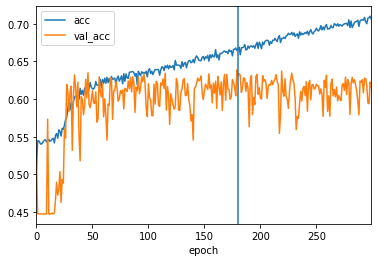

In [0]:
accuracy = train_history.plot.line(x='epoch',y=['acc', 'val_acc'])
accuracy.axvline(x=180)
a_fig = accuracy.get_figure()
a_fig.savefig(os.path.join(result_path, 'accuracy.jpg'))

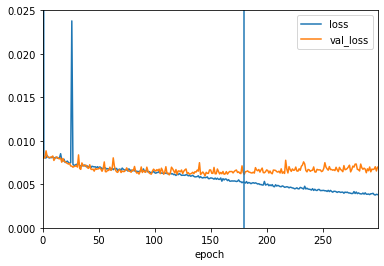

In [0]:
loss = train_history.plot.line(x='epoch',y=['loss', 'val_loss'])
loss.set_ylim(0, 0.025)
loss.axvline(x=180)
l_fig = loss.get_figure()
l_fig.savefig(os.path.join(result_path, 'loss.jpg'))

In [0]:
#TODO: Figure out how to use tensorboard in colab
#%tensorboard — logdir logs

UsageError: Line magic function `%tensorboard` not found.
